*KTH Royal Institute of Technology* \
DD2424 Deep Learning in Data Science | Project (grade A part)\
Diogo Paulo 030224-8216 (diogop@kth.se)\
Hugo Dezerto 011224-8257 (hugoad@kth.se) \
Maria Sebastião 031010-T207 (mcms2@kth.se)

# Grade A

In [1]:
# Just to check if the current working directory is correct

import os
os.getcwd()

'/home/jupyter/grade_A/Diogo'

## Semi-supervised Learning (with pseudo-labelling)

Using device: cuda

========== Fraction of labelled data: 1.0% ==========

Training with FC + last 1 ResNet block(s) unfrozen
l=1, Epoch 1/15, Train Loss: 3.8406, Val Acc: 3.80%, Val Loss: 3.6327
l=1, Epoch 2/15, Train Loss: 3.4986, Val Acc: 4.76%, Val Loss: 3.4970
l=1, Epoch 3/15, Train Loss: 3.1813, Val Acc: 8.70%, Val Loss: 3.3866
l=1, Epoch 4/15, Train Loss: 2.9126, Val Acc: 12.50%, Val Loss: 3.2886
l=1, Epoch 5/15, Train Loss: 2.6332, Val Acc: 15.90%, Val Loss: 3.1985
l=1, Epoch 6/15, Train Loss: 2.3488, Val Acc: 19.97%, Val Loss: 3.1134
l=1, Epoch 7/15, Train Loss: 2.1005, Val Acc: 23.51%, Val Loss: 3.0300
l=1, Epoch 8/15, Train Loss: 1.8672, Val Acc: 26.09%, Val Loss: 2.9484
l=1, Epoch 9/15, Train Loss: 1.6412, Val Acc: 28.12%, Val Loss: 2.8682
l=1, Epoch 10/15, Train Loss: 1.4232, Val Acc: 33.02%, Val Loss: 2.7896
l=1, Epoch 11/15, Train Loss: 1.2572, Val Acc: 36.14%, Val Loss: 2.7154
l=1, Epoch 12/15, Train Loss: 1.0125, Val Acc: 38.59%, Val Loss: 2.6446
l=1, Epoch 13/15, Trai

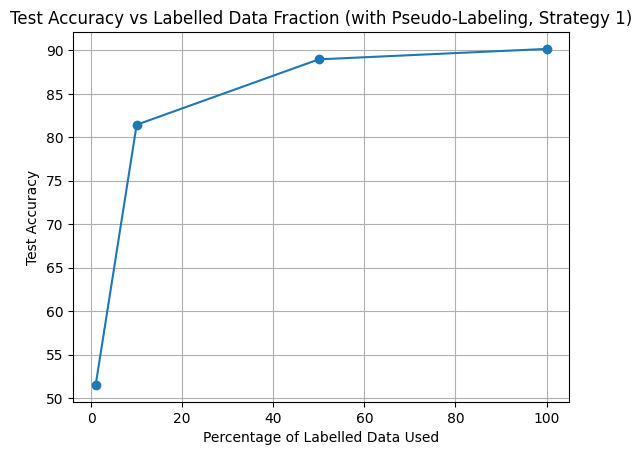

In [3]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

# --- Config ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

BATCH_SIZE = 64
NUM_CLASSES = 37
VAL_FRACTION = 0.2
NUM_EPOCHS = 15
LR_FC = 1e-3
LR_BACKBONE = 1e-5
FACTOR = 0.1
PATIENCE = 1
L2_LAMBDA = 0.0
MODEL_PREFIX = "semi_supervised_strategy1"
FRACTIONS = [0.01, 0.1, 0.5, 1.0]  # Labelled data fractions to test

# --- Transforms ---
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Dataset Wrappers ---
class TransformedDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)

class PseudoLabelledDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx].item()
    def __len__(self):
        return len(self.images)

# --- Utility Functions ---
def subsample_dataset(dataset, fraction, seed=42):
    np.random.seed(seed)
    targets = np.array([y for _, y in dataset])
    classes = np.unique(targets)
    indices = []
    for c in classes:
        class_indices = np.where(targets == c)[0]
        n_samples = max(1, int(len(class_indices) * fraction))
        indices.extend(np.random.choice(class_indices, n_samples, replace=False))
    np.random.shuffle(indices)
    return Subset(dataset, indices)

def generate_pseudo_labels(model, unlabelled_loader):
    model.eval()
    pseudo_images = []
    pseudo_labels = []
    with torch.no_grad():
        for imgs, _ in unlabelled_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            pseudo_images.append(imgs.cpu())
            pseudo_labels.append(preds.cpu())
    if pseudo_images:
        pseudo_images = torch.cat(pseudo_images)
        pseudo_labels = torch.cat(pseudo_labels)
        return PseudoLabelledDataset(pseudo_images, pseudo_labels)
    else:
        return None

def evaluate_model(model, loader, criterion=None):
    model.eval()
    correct = total = 0
    running_loss = 0.0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            if criterion:
                loss = criterion(outputs, labels)
                running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    avg_loss = running_loss / len(loader) if criterion else 0.0
    return accuracy, avg_loss

def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    return avg_loss

def get_unfrozen_params(model, l):
    # Unfreeze last l ResNet blocks (layer4, layer3, layer2, layer1)
    backbone_params = []
    if l >= 1:
        for param in model.layer4.parameters():
            param.requires_grad = True
            backbone_params.append(param)
    if l >= 2:
        for param in model.layer3.parameters():
            param.requires_grad = True
            backbone_params.append(param)
    if l >= 3:
        for param in model.layer2.parameters():
            param.requires_grad = True
            backbone_params.append(param)
    if l >= 4:
        for param in model.layer1.parameters():
            param.requires_grad = True
            backbone_params.append(param)
    return backbone_params

# From Grade E
def run_strategy1(train_loader, val_loader, test_loader, num_classes, num_epochs, lr_fc, lr_backbone, factor, patience, l2_lambda, model_prefix):
    best_val_acc = 0.0
    best_l = None
    val_accuracies_per_l = {}
    max_l = 4
    for l in range(1, max_l + 1):
        print(f"\nTraining with FC + last {l} ResNet block(s) unfrozen")
        model = resnet18(weights='IMAGENET1K_V1')
        for param in model.parameters():
            param.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        backbone_params = get_unfrozen_params(model, l)
        model = model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer_grouped_parameters = [
            {'params': model.fc.parameters(), 'lr': lr_fc}
        ]
        if backbone_params:
            optimizer_grouped_parameters.append({'params': backbone_params, 'lr': lr_backbone})
        optimizer = optim.Adam(optimizer_grouped_parameters, weight_decay=l2_lambda)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=factor, patience=patience)
        for epoch in range(num_epochs):
            avg_train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
            val_acc, val_loss = evaluate_model(model, val_loader, criterion)
            scheduler.step(val_acc)
            print(f"l={l}, Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.2f}%, Val Loss: {val_loss:.4f}")
        val_acc, _ = evaluate_model(model, val_loader, criterion)
        val_accuracies_per_l[l] = val_acc
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_l = l
            torch.save(model.state_dict(), f"{model_prefix}_l_{l}.pth")
            print(f"Saved new best model (l={l})")
    # Evaluate best model on test set
    print(f"\n--- Strategy 1 Finished ---")
    print(f"Best l based on validation accuracy: {best_l} (Accuracy: {val_accuracies_per_l[best_l]:.4f}%)")
    print(f"Loading and evaluating best model (l={best_l}) on the Test Set...")
    best_model = resnet18(weights=None)
    best_model.fc = nn.Linear(best_model.fc.in_features, num_classes)
    best_model.load_state_dict(torch.load(f"{model_prefix}_l_{best_l}.pth", weights_only=True))
    best_model = best_model.to(device)
    test_acc, _ = evaluate_model(best_model, test_loader, nn.CrossEntropyLoss())
    print(f"Final Test Accuracy (with best l={best_l} config): {test_acc:.4f}%")
    return test_acc, best_l

# --- Main Experiment Loop ---
def main():
    # Load datasets
    base_train_val_dataset = OxfordIIITPet(root='./dataset', split='trainval', target_types='category', download=True)
    test_dataset_raw = OxfordIIITPet(root='./dataset', split='test', target_types='category', download=True)
    # Split train/val
    num_train_val_samples = len(base_train_val_dataset)
    num_val_samples = int(VAL_FRACTION * num_train_val_samples)
    num_train_samples_for_split = num_train_val_samples - num_val_samples
    train_subset_raw, val_subset_raw = random_split(base_train_val_dataset, [num_train_samples_for_split, num_val_samples])
    # Apply transforms
    train_subset = TransformedDataset(train_subset_raw, transform=train_transform)
    val_subset = TransformedDataset(val_subset_raw, transform=test_transform)
    test_dataset = TransformedDataset(test_dataset_raw, transform=test_transform)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    results = []
    for frac in FRACTIONS:
        print(f"\n========== Fraction of labelled data: {frac*100:.1f}% ==========")
        # 1. Subsample labelled data
        labelled_subset = subsample_dataset(train_subset, frac)
        labelled_loader = DataLoader(labelled_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
        # 2. Unlabelled data (the rest)
        all_indices = set(range(len(train_subset)))
        labelled_indices = set(labelled_subset.indices)
        unlabelled_indices = list(all_indices - labelled_indices)
        unlabelled_subset = Subset(train_subset, unlabelled_indices)
        unlabelled_loader = DataLoader(unlabelled_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
        # 3. Train using Strategy 1 on labelled data
        t0 = time.time()
        test_acc, best_l = run_strategy1(
            labelled_loader, val_loader, test_loader, NUM_CLASSES, NUM_EPOCHS,
            LR_FC, LR_BACKBONE, FACTOR, PATIENCE, L2_LAMBDA, f"{MODEL_PREFIX}_frac{frac}"
        )
        t1 = time.time()
        print(f"Strategy 1 training time: {(t1-t0)/60:.2f} minutes")
        # 4. If not 100%, do pseudo-labeling and retrain
        if frac < 1.0 and len(unlabelled_subset) > 0:
            print("\n--- Pseudo-labeling phase ---")
            # Load best model from labelled training
            model = resnet18(weights=None)
            model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
            model.load_state_dict(torch.load(f"{MODEL_PREFIX}_frac{frac}_l_{best_l}.pth", weights_only=True))
            model = model.to(device)
            pseudo_labelled_dataset = generate_pseudo_labels(model, unlabelled_loader)
            if pseudo_labelled_dataset is not None and len(pseudo_labelled_dataset) > 0:
                combined_dataset = ConcatDataset([labelled_subset, pseudo_labelled_dataset])
                combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
                test_acc_semi, _ = run_strategy1(
                    combined_loader, val_loader, test_loader, NUM_CLASSES, NUM_EPOCHS,
                    LR_FC, LR_BACKBONE, FACTOR, PATIENCE, L2_LAMBDA, f"{MODEL_PREFIX}_frac{frac}_pseudo"
                )
                test_acc = test_acc_semi  # Use the semi-supervised accuracy for plotting
        results.append((frac, test_acc))
    # --- Plot results ---
    fractions, accuracies = zip(*results)
    plt.plot([f*100 for f in fractions], accuracies, marker='o')
    plt.xlabel('Percentage of Labelled Data Used')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy vs Labelled Data Fraction (with Pseudo-Labeling, Strategy 1)')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

| Labelled Fraction | Test Accuracy (Supervised) | Test Accuracy (Semi-supervised) |
|---|---|---|
| 1% | 42.90% | 51.51% |
| 10% | 77.81% | 81.44% |
| 50% | 89.02% | 88.96% |
| 100% | 90.16% | — |

# VITs

In [ ]:
pip install transformers datasets timm torch torchvision

In [1]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
from transformers import ViTForImageClassification, ViTImageProcessor, get_cosine_schedule_with_warmup
from torch.optim import AdamW
import numpy as np
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- 1. Load ViT processor and define transforms ---
model_name = "google/vit-base-patch16-224-in21k"
processor = ViTImageProcessor.from_pretrained(model_name)
mean = processor.image_mean
std = processor.image_std

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# --- 2. Load Oxford-IIIT Pet dataset (multi-class) ---
full_trainval_train = OxfordIIITPet(root='./dataset', split='trainval', target_types='category', transform=train_transform, download=True)
full_trainval_val = OxfordIIITPet(root='./dataset', split='trainval', target_types='category', transform=test_transform, download=True)
test_set = OxfordIIITPet(root='./dataset', split='test', target_types='category', transform=test_transform, download=True)

# --- 3. Split train/val indices ---
val_fraction = 0.2
num_val = int(len(full_trainval_train) * val_fraction)
num_train = len(full_trainval_train) - num_val
indices = np.random.permutation(len(full_trainval_train))
train_indices, val_indices = indices[:num_train], indices[num_train:]

train_set = Subset(full_trainval_train, train_indices)
val_set = Subset(full_trainval_val, val_indices)

# --- 4. DataLoaders ---
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

num_classes = 37

# --- 5. Load ViT model ---
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)
model = model.to(device)

# --- 6. Optimizer, Scheduler, Loss (LLRD) ---
epochs = 30
lr_backbone = 5e-5
lr_classifier = 2e-4
optimizer = AdamW([
    {"params": model.vit.parameters(), "lr": lr_backbone},
    {"params": model.classifier.parameters(), "lr": lr_classifier}
], weight_decay=1e-4)
num_training_steps = epochs * len(train_loader)
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps
)
criterion = torch.nn.CrossEntropyLoss()

# --- 7. Training & Evaluation ---
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs).logits
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

def train(model, train_loader, val_loader, epochs):
    best_val_acc = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs).logits
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()
        val_acc = evaluate(model, val_loader)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.4f} | Val Acc: {val_acc:.2f}%")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "vit_best_model.pth")
    print("Best validation accuracy:", best_val_acc)

start = time.time()
train(model, train_loader, val_loader, epochs)
print("Training time: %.2f minutes" % ((time.time()-start)/60))

# --- 8. Test Evaluation ---
model.load_state_dict(torch.load("vit_best_model.pth"))
test_acc = evaluate(model, test_loader)
print(f"Final Test Accuracy: {test_acc:.2f}%")

Using device: cuda


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/30 | Loss: 3.5546 | Val Acc: 33.29%
Epoch 2/30 | Loss: 3.1861 | Val Acc: 86.82%
Epoch 3/30 | Loss: 2.3230 | Val Acc: 91.44%
Epoch 4/30 | Loss: 1.3402 | Val Acc: 93.75%
Epoch 5/30 | Loss: 0.7221 | Val Acc: 95.11%
Epoch 6/30 | Loss: 0.4128 | Val Acc: 94.16%
Epoch 7/30 | Loss: 0.2513 | Val Acc: 94.57%
Epoch 8/30 | Loss: 0.1642 | Val Acc: 92.93%
Epoch 9/30 | Loss: 0.1125 | Val Acc: 94.29%
Epoch 10/30 | Loss: 0.0873 | Val Acc: 94.29%
Epoch 11/30 | Loss: 0.0720 | Val Acc: 94.02%
Epoch 12/30 | Loss: 0.0628 | Val Acc: 94.29%
Epoch 13/30 | Loss: 0.0560 | Val Acc: 94.16%
Epoch 14/30 | Loss: 0.0427 | Val Acc: 94.70%
Epoch 15/30 | Loss: 0.0370 | Val Acc: 94.43%
Epoch 16/30 | Loss: 0.0392 | Val Acc: 94.02%
Epoch 17/30 | Loss: 0.0316 | Val Acc: 94.29%
Epoch 18/30 | Loss: 0.0299 | Val Acc: 94.84%
Epoch 19/30 | Loss: 0.0269 | Val Acc: 94.70%
Epoch 20/30 | Loss: 0.0239 | Val Acc: 94.70%
Epoch 21/30 | Loss: 0.0244 | Val Acc: 95.11%
Epoch 22/30 | Loss: 0.0221 | Val Acc: 94.84%
Epoch 23/30 | Loss:

**Test Accuracy**: 92.34%

# LoRA layers

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import OxfordIIITPet
from torchvision.models import resnet18, resnet34, resnet50
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import math
import time

# 1. Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. LoRA module for Conv2d layers (used only in layer4)
class LoRAConv2d(nn.Module):
    def __init__(self, conv, r=8, alpha=16, dropout=0.1):
        super().__init__()
        self.conv = conv
        self.r = r
        self.alpha = alpha
        self.dropout = nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()

        # Use 1x1 convs for LoRA adapters (to match Hugo's implementation)
        in_channels = conv.in_channels
        out_channels = conv.out_channels
        
        kernel_size = conv.kernel_size
        padding = conv.padding
        
        stride = conv.stride
        dilation = conv.dilation
        self.lora_A = nn.Conv2d(in_channels, r, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=False)

        #self.lora_A = nn.Conv2d(in_channels, r, kernel_size=1, bias=False)
        self.lora_B = nn.Conv2d(r, out_channels, kernel_size=1, bias=False)
        nn.init.kaiming_uniform_(self.lora_A.weight, a=math.sqrt(5))
        nn.init.zeros_(self.lora_B.weight)
        self.scaling = alpha / r

        # Freeze the original conv weights and bias
        for param in self.conv.parameters():
            param.requires_grad = False

    def forward(self, x):
        result = self.conv(x)
        lora_out = self.dropout(x)
        lora_out = self.lora_A(lora_out)
        lora_out = self.lora_B(lora_out)
        result = result + self.scaling * lora_out
        return result


# Count all parameters in the model (before freezing)
def count_all_params(model, msg="Total parameters in model: "):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{msg} {total:,} (trainable: {trainable:,})")

# Count trainable parameters in layer4
def count_layer4_params(model, msg="Trainable parameters in layer4: "):
    layer4_params = sum(p.numel() for p in model.layer4.parameters() if p.requires_grad)
    print(f"{msg} {layer4_params:,}")


def count_lora_params(model):
    lora_params = 0
    for layer in [model.layer2, model.layer3, model.layer4]:
        for block in layer:
            if isinstance(block.conv2, LoRAConv2d):
                lora_params += sum(p.numel() for p in block.conv2.parameters() if p.requires_grad)
    print(f"Total trainable LoRA parameters in layer2, layer3, layer4: {lora_params:,}")

# 3. Data transforms (augmentation for train, normalization for all)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 4. Load dataset and split train/val
full_train_dataset = OxfordIIITPet(root='./dataset', split='trainval', target_types='category', download=True)
test_dataset = OxfordIIITPet(root='./dataset', split='test', target_types='category', transform=test_transform, download=True)

val_fraction = 0.2
num_val = int(len(full_train_dataset) * val_fraction)
num_train = len(full_train_dataset) - num_val
train_subset, val_subset = random_split(full_train_dataset, [num_train, num_val])

# 5. Apply transforms to subsets
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return self.transform(x), y
    def __len__(self):
        return len(self.subset)

train_dataset = TransformedDataset(train_subset, train_transform)
val_dataset = TransformedDataset(val_subset, test_transform)

# 6. Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

"""# 7. Model setup: LoRA only in layer4, unfreeze last 2 blocks
model = resnet50(weights='IMAGENET1K_V1')
count_all_params(model, msg="All parameters in model before freezing: ")

# Freeze all parameters first
# for param in model.parameters():
#     param.requires_grad = False

# Count before LoRA
#count_layer4_params(model, msg="Trainable in layer4 before LoRA: ")

# Replace Conv2d layers in layer4 with LoRA-augmented Conv2d
# for layer in [model.layer2, model.layer3, model.layer4]:
#     for block in layer:
#         block.conv2 = LoRAConv2d(block.conv2, r=8, alpha=16, dropout=0.1)

# Count after LoRA
#count_layer4_params(model, msg="Trainable in layer4 after LoRA: ")
# After wrapping conv2 in all layers with LoRAConv2d
#count_lora_params(model)

# Use standard fully connected layer (no LoRA in fc)
model.fc = nn.Linear(model.fc.in_features, 37)

# 8. Optimizer and loss setup (layer-wise learning rates)
params = [
    {'params': model.fc.parameters(), 'lr': 1e-3},
    {'params': model.layer4.parameters(), 'lr': 1e-4},
    {'params': model.layer3.parameters(), 'lr': 1e-4},
    {'params': model.layer2.parameters(), 'lr': 1e-4},
]
optimizer = optim.Adam(params, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=1)

model = model.to(device)"""


# 9. Training with validation and checkpointing
def train(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=15):
    best_val_acc = 0
    best_state = None
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        val_acc = test(model, val_loader)
        scheduler.step(val_acc)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val Acc: {val_acc:.2f}%")
        # Print GPU memory usage after each epoch (if using CUDA)
        if torch.cuda.is_available():
            print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
            print(f"GPU max memory allocated: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()
    if best_state:
        model.load_state_dict(best_state)
    return best_val_acc

# 10. Evaluation function
def test(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

# 11. Run training and evaluation
# start_time = time.time()
# print("Starting improved ResNet18+LoRA (layer4 only) fine-tuning...")
# best_val_acc = train(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=10)
# test_acc = test(model, test_loader)
# print(f"Best Val Accuracy: {best_val_acc:.2f}%")
# print(f"Test Accuracy (best model): {test_acc:.2f}%")

# end_time = time.time()
# elapsed = end_time - start_time
# print(f"Total computation time: {elapsed/60:.2f} minutes ({elapsed:.2f} seconds)")

experiment_settings = [
    #(4, 4),
    (4, 8),
    #(8, 8),
    #(8, 16),
]

results = []

for r, alpha in experiment_settings:
    print(f"\n=== Running with r={r}, alpha={alpha} ===")
    # Re-initialize model and freeze all params
    model = resnet34(weights='IMAGENET1K_V1')
    """print("Conv2 parameters:")
    dor layer in [model.layer2, model.layer3, model.layer4]:
        for block in layer:
            print(f"  {layer.__class__.__name__}.{block.__class__.__name__}:")
            print(f"    in_channels: {block.conv2.in_channels}")
            print(f"    out_channels: {block.conv2.out_channels}")
            print(f"    kernel_size: {block.conv2.kernel_size}")
            print(f"    stride: {block.conv2.stride}")
            print(f"    padding: {block.conv2.padding}")
            print(f"    dilation: {block.conv2.dilation}")"""
            
    #count_all_params(model, msg="All parameters in model before freezing: ")
    
    for param in model.parameters():
        param.requires_grad = False

    # Apply LoRA to conv2 in layer2, layer3, layer4
    for layer in [model.layer2, model.layer3, model.layer4]:
        for block in layer:
            block.conv2 = LoRAConv2d(block.conv2, r=r, alpha=alpha, dropout=0.1)

    count_lora_params(model)
    # Replace FC layer
    model.fc = nn.Linear(model.fc.in_features, 37)
    fc_params = sum(p.numel() for p in model.fc.parameters())
    print(f"Number of parameters in the fc layer: {fc_params:,}")
    model = model.to(device)

    # Optimizer and scheduler
    params = [
        {'params': model.fc.parameters(), 'lr': 1e-3},
        {'params': model.layer4.parameters(), 'lr': 1e-4},
        {'params': model.layer3.parameters(), 'lr': 1e-4},
        {'params': model.layer2.parameters(), 'lr': 1e-4},
    ]
    optimizer = optim.Adam(params, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=1)

    start_time = time.time()

    # Train and evaluate
    best_val_acc = train(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=15)
    test_acc = test(model, test_loader)
    print(f"r={r}, alpha={alpha} -> Best Val Acc: {best_val_acc:.2f}%, Test Acc: {test_acc:.2f}%")
    results.append((r, alpha, best_val_acc, test_acc))

    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Total computation time: {elapsed/60:.2f} minutes ({elapsed:.2f} seconds)")

print("\nSummary of results:")
for r, alpha, val_acc, test_acc in results:
    print(f"r={r}, alpha={alpha} -> Val: {val_acc:.2f}%, Test: {test_acc:.2f}%")
